# Mission pilot

In this pilot, we are developing indicators to evaluate the impact of innovation missions.

We are doing this with Gateway to Research and Horizon 2020 data, and with two two missions in mind. They are:

* Use of AI to diagnose, prevent and treat chronic diseases
* Improve quality of life for an aging population

We want to write a pipeline that more or less automatically takes keywords related to missions, queries the data and generates indicators and visualisations.

The two datasets we are working with have similar structures (*projects linked to organisations and outcomes*) so it would be nice to write a pipeline that allows us to move between sources seamlessly.

The output will be a methodology and preliminary findings for a EURITO working paper. Emerging findings will also be relevant for the project mapping innovation in Scotland.

## Tasks

1. Load and explore GtR data
  * Link between projects and outcomes
  * Coverage of outcomes
  
2. Process GtR data
  * Classify projects into disciplines
  * Label projects with TRLs (this will come from other team-members)

3. Create mission fields
  * Generate mission-related keywords
  * Query the data

4. Generate indicators
  * Level of activity per mission
  * Evolution of activity per mission (absolute and normalised)
  * Network structure of mission
    * Interdisciplinary activity and its evolution
    * Communities involved
    * % of relevant fields involved in mission (eg how much of total AI activity is about chronic diseases; how much of aging is about quality of life and well-being)?
  * Technological maturity of fields
    * Explore distribution of outcomes by mission area
    * Generate lists of DOIs (papers) for cross-ref analysis
    
5. Report
   









### 0. Preamble

#### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Functions

def missing_count(df,ax):
    '''
    Creates a barchart with share of missing values by variable in the data
    
    '''
    
    df.apply(lambda x: pd.isnull(x),axis=1).mean().sort_values(ascending=False).plot.bar(ax=ax,color='blue')
    
def get_year(date):
    '''
    Extracts years from GTR data. These are strings so we just get the first number
    '''
    
    if pd.isnull(date)==False:
        y = date.split('-')[0]
        return(int(y))
    
    else:
        return(np.nan)



### 1. Load GtR data

We will load the data in a different Notebook (we need a special environment to use the data getters)

In [3]:
my_tables = ['_projects','_organisations','_products','_intellectualproperties','_publications',
             'technicalproducts',
             '_spinouts','_link_table']

In [4]:
all_tables = os.listdir('../data/external/')

#A dict where every item is a df with the key = table name. We do a bit of string manipulation to remove dates etc.
my_data = {file.split('_')[-1][:-4]:pd.read_csv('../data/external/'+file).iloc[:,1:] for file in all_tables if any(x in file for x in my_tables)}


/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [5]:
#Load the linking file here because we will use it throughout
link = my_data['table']

link.head()

,id,project_id,rel,table_name
0,00000C13-59F1-419B-9204-77DAFFD2BC35,D80FFDA0-64E3-4DB9-AE0D-2ECEBBDF2081,PUBLICATION,gtr_outcomes_publications
1,00000D8A-3BFA-4D6C-BB58-8721DA8D36E1,F229B185-CBF1-40D3-94B5-D47996220858,PUBLICATION,gtr_outcomes_publications
2,00002C86-98D2-4681-992A-E6F180D197C0,5237EE5C-D46C-43E1-92AA-C0C73F5B291B,PI_PER,gtr_persons
3,00002C86-98D2-4681-992A-E6F180D197C0,92491E00-537A-4072-8877-A9D155E7FA73,SUPER_PER,gtr_persons
4,00002C86-98D2-4681-992A-E6F180D197C0,C158930D-8AEF-4026-930E-6E7FFD9D9A26,PI_PER,gtr_persons


### Projects

In [6]:
projects = my_data['projects']

projects.head()

,id,end,title,status,grantCategory,leadFunder,abstractText,start,created,leadOrganisationDepartment,potentialImpact,techAbstractText
0,00006CB7-61E0-4946-B7DB-DAE09ED63DE4,NaN,Construction Site Monitoring,Closed,Vouchers,Innovate UK,We take aerial photos of construction sites us...,NaN,2018-11-08 11:38:37,NaN,NaN,NaN
1,0003C360-5DB8-4930-8266-6218C633A504,NaN,The 'Authoritarian Turn' in Environmental Gove...,Active,Studentship,ESRC,This research will investigate the possibility...,NaN,2018-11-08 11:38:37,Architecture Planning and Landscape,NaN,NaN
2,000423DA-5A37-4E62-A698-703985CD4E6E,NaN,Proton-driven plasma wakefield acceleration---...,Closed,Research Grant,STFC,"Over the last fifty years, accelerators of eve...",NaN,2018-11-08 11:38:37,Physics and Astronomy,This project is naturally a multi-disciplinary...,NaN
3,000424B1-378E-4AB6-BAEC-CD8607AE08A9,NaN,Mechanisms mediating axon outgrowth in the Dro...,Closed,Research Grant,BBSRC,We are dependent on our nervous system functio...,NaN,2018-11-08 11:38:37,Developmental Neurobiology,The research in this proposal will have a numb...,The formation of the nervous system requires t...
4,0004C698-0B51-4665-8593-1082BBF58C06,NaN,"Ultrahigh resolution NMR: citius, altius, fortius",Active,Research Grant,EPSRC,Understanding the structures and behaviour of ...,NaN,2018-11-08 11:38:37,Chemistry,Who will benefit from this research?\n\nNMR is...,NaN


Some rapid observations:

* what does start mean?
* What does created mean?
* abstractText seems to be the main textual description

Text(0.5,1,'Missing values in Project GTR data')

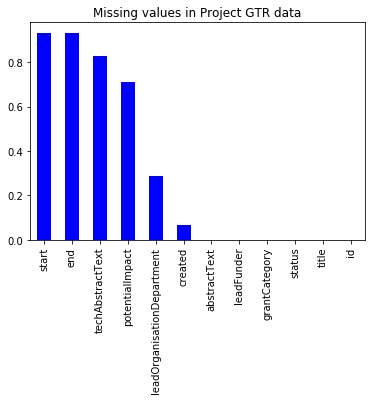

In [7]:
fig,ax = plt.subplots()

missing_count(projects,ax)

ax.set_title('Missing values in Project GTR data')

In [8]:
projects['year_created'] = projects['created'].apply(lambda x: get_year(x))

projects['year_created'].value_counts()

2018.0    80997
Name: year_created, dtype: int64

Created is a data collection variable

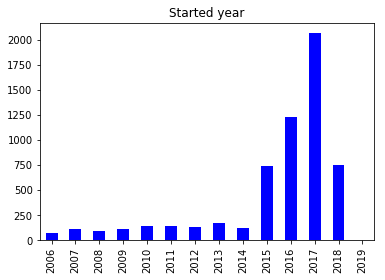

In [9]:
projects['year_started'] = projects['start'].apply(lambda x: get_year(x))

projects['year_started'].value_counts().loc[np.arange(2006,2020)].plot.bar(color='blue',title='Started year')

Not sure about what `year_stared` means but it doesn't cover many records

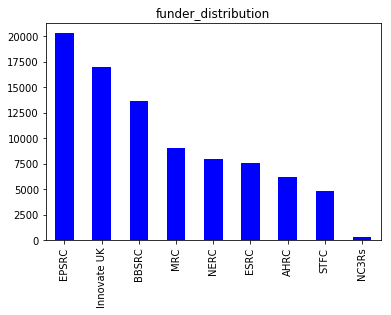

In [10]:
projects['leadFunder'].value_counts().plot.bar(color='blue',title='funder_distribution')

EPSRC and Innovate UK are the most active organisations in the data

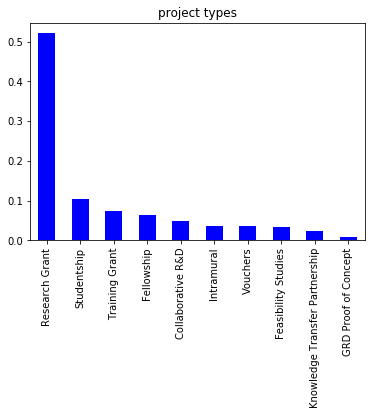

In [11]:
projects['grantCategory'].value_counts(normalize=True)[:10].plot.bar(color='blue',title='project types')

Research grants are the main category with almost half of the observations

##### Does the fund data contain the actual start and end date for the project?

In [12]:
fund = pd.read_csv('../data/external/2019-01-18_gtr_funds.csv').iloc[:,1:]

In [13]:
fund.head()

,id,end,start,category,amount,currencyCode
0,00006E7F-2E72-4CE6-81D4-2B603E5E4526,2018-09-30 01:00:00,2014-08-01 01:00:00,INCOME_ACTUAL,379758,GBP
1,00009856-0B8F-406E-ABC6-F56064AE88E4,2020-11-30 00:00:00,2018-08-01 01:00:00,INCOME_ACTUAL,110498,GBP
2,0000FBA5-BA5E-423A-8EAC-1EC4D3F03EB2,2020-04-30 01:00:00,2017-11-01 00:00:00,INCOME_ACTUAL,953077,GBP
3,0001442B-7B32-4198-A0A2-D0DC0A2C1076,2018-07-31 01:00:00,2015-05-01 01:00:00,INCOME_ACTUAL,617049,GBP
4,00043BED-0B22-4843-BE42-6A7F905AD78B,2012-12-31 00:00:00,2007-07-01 01:00:00,EXPENDITURE_PROJECTED,224395,GBP


In [14]:
fund.shape

(86904, 6)

One fund per project. Bodes well

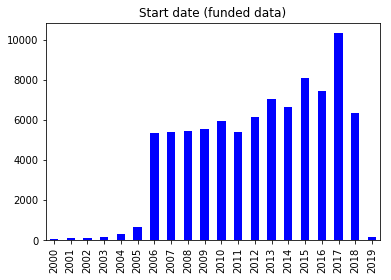

In [15]:
fund['year'] = fund['start'].apply(lambda x: get_year(x))

fund['year'].value_counts().loc[np.arange(2000,2020)].plot.bar(color='blue',title='Start date (funded data)')

The dataset begins in 2016. What is the bump in 2017?

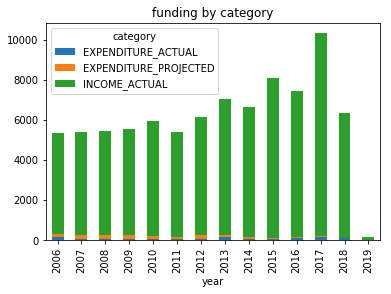

In [16]:
pd.crosstab(fund['category'],fund['year'])[np.arange(2006,2020)].T.plot.bar(stacked=True,title='funding by category')

Most of the funding levels in the data reflect income

#### Merge funding with projects to get dates and funding by project

`projects_f = projects merged w/ funding`

In [60]:
#Merge everything. It works

projects_f = pd.merge(
    pd.merge(fund,link,left_on='id',right_on='id'),
    projects,
    left_on='project_id',right_on='id')

In [61]:
projects_f.head()

,id_x,end_x,start_x,category,amount,currencyCode,year,project_id,rel,table_name,...,grantCategory,leadFunder,abstractText,start_y,created,leadOrganisationDepartment,potentialImpact,techAbstractText,year_created,year_started
0,00006E7F-2E72-4CE6-81D4-2B603E5E4526,2018-09-30 01:00:00,2014-08-01 01:00:00,INCOME_ACTUAL,379758,GBP,2014,82E47A5E-A4C6-4F70-9242-821EFC9456D7,FUND,gtr_funds,...,Research Grant,STFC,It is just over 100 years since Ernest Rutherf...,NaN,2018-11-08 11:38:37,School of Engineering,This STFC-funded research will have a consider...,NaN,2018.0,NaN
1,00009856-0B8F-406E-ABC6-F56064AE88E4,2020-11-30 00:00:00,2018-08-01 01:00:00,INCOME_ACTUAL,110498,GBP,2018,BF4F71FC-4282-48F9-97B5-BFBC1A2081F4,FUND,gtr_funds,...,Knowledge Transfer Partnership,Innovate UK,"To develop, validate and implement statistical...",NaN,2018-11-08 11:38:37,NaN,NaN,NaN,2018.0,NaN
2,0000FBA5-BA5E-423A-8EAC-1EC4D3F03EB2,2020-04-30 01:00:00,2017-11-01 00:00:00,INCOME_ACTUAL,953077,GBP,2017,6A660023-1ACB-4804-9D46-424F7AD7F46A,FUND,gtr_funds,...,Research Grant,EPSRC,The technology of paper is so old and so ubiqu...,NaN,2018-11-08 11:38:37,Digital World Research Centre,A next generation paper (beyond '1GP') will op...,NaN,2018.0,NaN
3,0001442B-7B32-4198-A0A2-D0DC0A2C1076,2018-07-31 01:00:00,2015-05-01 01:00:00,INCOME_ACTUAL,617049,GBP,2015,3D74C63B-E591-4715-8588-27DE88A83BA2,FUND,gtr_funds,...,Research Grant,BBSRC,Photoreceptors transduce light into electrical...,NaN,2018-11-08 11:38:37,Physiology Development and Neuroscience,The immediate impact of the work in this propo...,Drosophila phototransduction is mediated by a ...,2018.0,NaN
4,00043BED-0B22-4843-BE42-6A7F905AD78B,2012-12-31 00:00:00,2007-07-01 01:00:00,EXPENDITURE_PROJECTED,224395,GBP,2007,D4BFE45F-51D8-4AD3-8F50-A3046D4C039F,FUND,gtr_funds,...,Intramural,BBSRC,The &quot;Green Revolution&quot; dwarfing (Rht...,NaN,2018-11-08 11:38:37,Contracts Office,NaN,NaN,2018.0,NaN


Lots of guff there. I should tidy it up later

#### Let's also check the Topics: does this refer to project keywords?

In [19]:
topics = pd.read_csv('../data/external/2019-01-18_gtr_topic.csv').iloc[:,1:]

topics.head()

,id,text,topic_type
0,006DC612-6329-4D37-A540-5FB2CA634720,5.5 Radiotherapy,researchActivity
1,008D950C-182A-427B-A7CB-4FD430D040B5,Physical Organic Chemistry,researchTopic
2,00C03EE8-351D-40B5-A0D4-06C45592BFF6,Nuclear structure,researchTopic
3,00E432A0-CF0E-42D0-BAF1-6872995B42EF,Part. Phys/Astron. Instrument.,researchTopic
4,01AC56BC-45B4-434D-B015-7C879327F09F,Parallel Computing,researchTopic


In [20]:
topics['topic_type'].value_counts()

researchTopic       593
researchSubject      82
researchActivity     49
healthCategory       22
rcukProgramme         2
Name: topic_type, dtype: int64

Yes. What are their keys in the linked_table?

In [21]:
link['table_name'].value_counts()

gtr_outcomes_publications                    718681
gtr_outcomes_disseminations                  234299
gtr_organisations                            224268
gtr_persons                                  185977
gtr_outcomes_collaborations                   97339
gtr_funds                                     86879
gtr_outcomes_furtherfundings                  65080
gtr_outcomes_keyfindings                      27970
gtr_outcomes_policyinfluences                 22933
gtr_outcomes_impactsummaries                  19317
gtr_projects                                  17986
gtr_outcomes_researchmaterials                15761
gtr_outcomes_researchdatabaseandmodels        10393
gtr_outcomes_artisticandcreativeproducts       7124
gtr_outcomes_softwareandtechnicalproducts      6299
gtr_outcomes_intellectualproperties            4023
gtr_outcomes_products                          2120
gtr_outcomes_spinouts                           989
Name: table_name, dtype: int64

The `topics_table` is missing above

### Organisations


In [22]:
orgs = my_data['organisations']

orgs.head()

,id,name,addresses,projectCost,grantOffer
0,0003EB78-07B9-400E-AE39-2AD612C28612,Wentworth Laboratories Ltd,{'address': {'id': '18A52282-3BCD-483D-A32F-F3...,NaN,NaN
1,0005728F-26ED-465D-8DCE-C49F181EDB2E,Duchy Parade Films,{'address': {'id': '1788E06A-79D8-492F-9988-62...,NaN,NaN
2,0005AEA8-B99E-4063-973E-FF16602F9CCF,"German Mouse Clinic, Helmholtz Zentrum Münster",NaN,NaN,NaN
3,000775C1-64AC-4140-A8EC-9C4B337DB8EE,Dynamic Boosting Systems Limited,{'address': {'id': 'E143A689-8121-40FB-968D-46...,319806.0,143913.0
4,0007ED76-4B09-4B09-A39F-D4B75BD36486,Hildersham Village History Recorders,NaN,NaN,NaN


In [23]:
orgs.shape

(38868, 5)

This will be interesting to look at collaboration networks between organisations.

Note that this is likely to over-estimate collaboration given that departments (which might be disconnected) will be subsumed under organisations. Maybe we could use the persons data to unpick that?

### Outputs

Brief exploration of the data and standardisation with a single schema (for merging with projects)

#### Products

In [24]:
products = my_data['products']

In [25]:
products.head()

,id,title,description,type,stage,status,yearDevelopmentCompleted,impact,supportingUrl
0,0003293D-247D-4BF1-9674-402A70504D64,Normothermic machine liver perfusion of discar...,Deaths from liver disease have soared by 40 pe...,Therapeutic Intervention - Medical Devices,Early clinical assessment,Under active development/distribution,2016.0,First human liver transplantation using a marg...,NaN
1,0047A6B5-2377-47A1-8D63-360B5400E5B9,Novel compounds with antibacterial activity,Dr. Andrews team has synthesised several novel...,Therapeutic Intervention - Drug,Initial development,Under active development/distribution,2016.0,Dr Andrews work takes a novel approach by incr...,NaN
2,0053E133-D736-4942-AFF0-4453B81FF255,chronic pain treatment 2,we are developing a reformulation of an existi...,Therapeutic Intervention - Drug,Late clinical evaluation,Under active development_distribution,2010.0,We seek to develop this first as a special and...,NaN
3,006EAF83-4FB6-438F-B3C4-C23D5C44F6B8,Antibiotics in miscarriage surgery,The AIMS (Antibiotics in Miscarriage Surgery) ...,Therapeutic Intervention - Drug,Late clinical evaluation,Under active development/distribution,2013.0,Please refer to other sections of the portfoli...,http://www.ammalife.org/research/aims-antibiot...
4,0084F278-D81F-4F70-86AE-0DB7CE0A41BD,GMP thymidine phosphorylase,The manufacture of two GMP batches of thymidin...,Therapeutic Intervention - Cellular and gene t...,Early clinical assessment,Under active development/distribution,2018.0,This material will be used in our clinical tri...,NaN


In [26]:
products.shape

(2120, 9)

They seem to be primarily medical products

In [27]:
products.stage.value_counts()

Initial development          589
Early clinical assessment    525
Late clinical evaluation     299
Refinement.  Non-clinical    257
Refinement.  Clinical        176
Small-scale adoption         123
Wide-scale adoption           77
Market authorisation          42
Name: stage, dtype: int64

In [28]:
products.type.value_counts()

Therapeutic Intervention - Drug                                      601
Diagnostic Tool - Non-Imaging                                        321
Therapeutic Intervention - Medical Devices                           176
Diagnostic Tool - Imaging                                            130
Therapeutic Intervention - Vaccines                                  103
Therapeutic Intervention - Cellular and gene therapies               101
Support Tool - For Medical Intervention                              100
Preventative Intervention - Behavioural risk modification            100
Management of Diseases and Conditions                                 95
Support Tool - For Fundamental Research                               91
Therapeutic Intervention - Psychological/Behavioural                  88
Preventative Intervention - Nutrition and Chemoprevention             38
Therapeutic Intervention - Surgery                                    33
Health and Social Care Services                    

Yes - this is clearly a medical database. We might use it for our two missions given their health focus

#### Intellectual Property

In [29]:
ip = my_data['intellectualproperties']

ip.head()

,id,title,description,protection,patentId,yearProtectionGranted,impact,licensed
0,00042331-9D9F-48B3-AF06-3546D8BAC01D,FBG strain sensor,Design of FBG-based sensor for monitoring corr...,Patent application published,GB2439993-2008-01-16,2008,This will make an impact in the construction i...,No
1,000670D2-9E0E-401F-96F8-594DF4599FD7,Analogs of alpha ceramide (IMM47) and uses the...,Analogs of alpha ceramide (IMM47) and uses the...,Patent granted,6836514.7,2007,"In this patent, which underpinned my subsequen...",Yes
2,001A3285-86DE-4DEE-8D6B-C1D92BE6CDFC,IDENTIFICATION AND DISPLAY OF PEPTIDE LIGANDS,An in vitro drug discovery platform analogous ...,Patent application published,WO 2015/011467,2015,z,No
3,001F8DBA-72DA-49F6-8588-628088BCCCB1,LIST BASED PREFETCH,Invention of a pattern-recording gather prefet...,Patent granted,US8255633,2012,Used in IBM's HPC products,Com
4,0024B4B4-BB74-4AC1-8D68-F2771E80383B,Terahertz radiation detector focal plane array...,A CMOS based focal plane for terahertz imaging...,Patent granted,US9513171,2016,Collaboration with industry on photonics techn...,Com


In [30]:
ip.shape

(4023, 8)

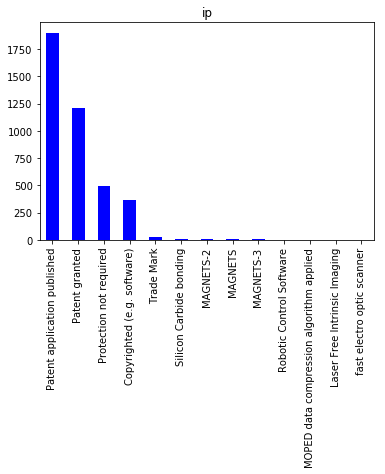

In [31]:
ip.protection.value_counts().plot.bar(color='blue',title='ip')

Around 3000 patents and a bunch of random labels. We can use it perhaps to look at field maturity

#### Technical products

In [32]:
technical = my_data['softwareandtechnicalproducts']

technical.head()

,id,title,description,type,impact,softwareOpenSourced,yearFirstProvided,supportingUrl
0,00043B35-DCD5-4C1C-B5FF-FD2B451AABF0,cath-cluster: A simple way to complete-linkage...,The software provides a fast implementation of...,Software,The software has increased visibility of our g...,True,2018.0,http://cath-tools.readthedocs.io/en/latest/too...
1,00050BA4-9FA9-405E-9210-6DB9C888DD4C,Submarine Canyons: guest post,website by Siddhi Joshi,Software,NaN,NaN,NaN,http://seabedhabitats.org/2013/06/24/submarine...
2,0013CA23-C0A9-4537-80AE-641CEBD36AAC,AutoLens,AutoLens is a new piece of strong gravitationa...,Software,Expectations are that AutoLens or at least man...,NaN,2018.0,NaN
3,0018C0C7-60CA-4DAD-93A2-0BA2F9278E22,Bite plate,The bite plate is a 9.5x4cm flat section of me...,Physical Model/Kit,The bite plate improves the interpretability o...,NaN,2011.0,http://www.seeingspeech.arts.gla.ac.uk/uti/Rec...
4,001DAD51-73B7-492E-8B0A-8C54578FCD9B,QKgenome,A set of scripts for converting genomes based ...,Software,Used in several manuscripts in preparation to ...,True,2017.0,https://github.com/matthewmoscou/QKgenome


In [33]:
technical.shape

(6299, 8)

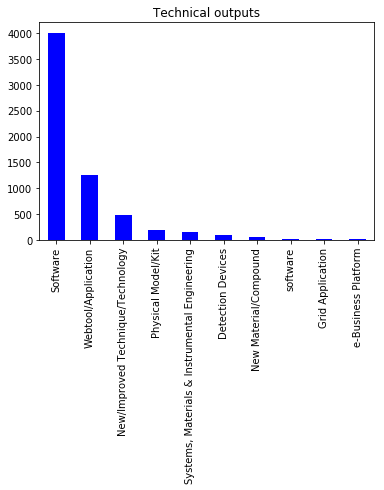

In [34]:
technical['type'].value_counts().plot.bar(color='blue',title='Technical outputs')

Perhaps we could create a 'practical output' dummy for the field...

Or query the application databases with project names once we have identified them?

In [35]:
np.sum(['github' in x for x in technical.supportingUrl if pd.isnull(x)==False])

864

864 projects in GitHUb

#### Spinouts

In [36]:
spinouts = my_data['spinouts']

spinouts.head()

,id,description,companyName,impact,website,yearEstablished
0,00835229-1A18-4731-BA53-F13EFFF8C4C7,Scientific text mining,Scidiver,None so far.,NaN,2011.0
1,00911DF1-AF41-42EC-BB95-6FC28E86786C,Cognition Video is a platform for the automati...,Cognition Video Ltd.,Cognition Video won the Enterprise Software ca...,http://www.cognitionvideo.co.uk,2016.0
2,00958DA0-A15A-4DA0-B2EF-056E21C44BFE,To exploit the sensors and composites innovati...,Sensors and Composites Ltd,Incorporated in 2015.,NaN,2015.0
3,00CC435B-DCD1-407A-9BF5-3F82240703E3,The company specializes in the area of manufac...,VitriTech Ltd,Technology for laser gain manufacturing has be...,http://www.vitritech.co.uk/,2015.0
4,00D37433-E0BE-42DF-AAD7-97358F2BA4F0,One of the researchers Dr. Helen Yin was award...,THz Power Ltd,The impact of the spinout company could be gre...,http://thzpower.com/about.html,2014.0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


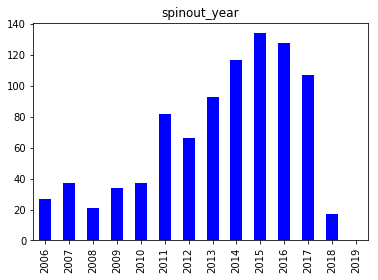

In [37]:
spinouts.yearEstablished.value_counts().loc[np.arange(2006,2020)].plot.bar(color='blue',title='spinout_year')

#### Publications

In [38]:
pubs = my_data['publications']

pubs.head()

,id,title,type,journalTitle,datePublished,publicationUrl,pubMedId,issn,volumeTitle,doi,issue,author,isbn,chapterTitle,pageReference
0,00000C13-59F1-419B-9204-77DAFFD2BC35,Characteristics of EGRET Blazars in the VLBA I...,Journal Article/Review,The Astrophysical Journal,2007-01-01,http://dx.doi.org/10.1086/523264,NaN,NaN,NaN,http://dx.doi.org/10.1086/523264,2,Taylor G,NaN,NaN,NaN
1,00000D8A-3BFA-4D6C-BB58-8721DA8D36E1,The cytotoxicity and cell labelling efficacy o...,Working Paper,NaN,2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,Samantha Parsons (Author),NaN,NaN,NaN
2,000030A0-2369-4D9A-8126-E68EE6FD653F,Altered receptor specificity and cell tropism ...,Journal Article/Review,Journal of virology,2010-01-01,http://europepmc.org/abstract/MED/20826688,20826688.0,0022-538X,84,http://dx.doi.org/10.1128/JVI.01639-10,22,Liu Y,NaN,NaN,NaN
3,0000428D-17F4-4E75-BD8A-8584675CAFAB,Nonlocal energy density functionals for pairin...,Journal Article/Review,Journal of Physics G: Nuclear and Particle Phy...,2017-01-01,http://dx.doi.org/10.1088/1361-6471/aa5fd7,NaN,NaN,NaN,http://dx.doi.org/10.1088/1361-6471/aa5fd7,4,Bennaceur K,NaN,NaN,NaN
4,00004ECB-A5B9-4940-8E49-9060E46C2F83,Superalloys 2012 - Huron/Superalloys,Book Chapter,NaN,2012-01-01,http://dx.doi.org/10.1002/9781118516430.ch33,NaN,NaN,NaN,http://dx.doi.org/10.1002/9781118516430.ch33,NaN,Pang H,9780470943205,Effects of Y and La Additions on the Processin...,301-310


In [39]:
np.random.randint(0,len(pubs),40000)

array([399571, 339454, 449700, ..., 140211, 475552, 267635])

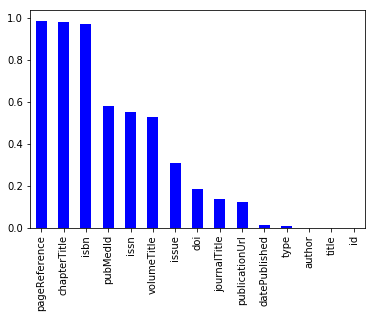

In [40]:
#Get missing values for a random sample (10%) of the publications

fig,ax = plt.subplots()

pub_sample = pubs.loc[list(np.random.randint(0,len(pubs),70000)),:]

missing_count(pub_sample,ax)


80% have DOI

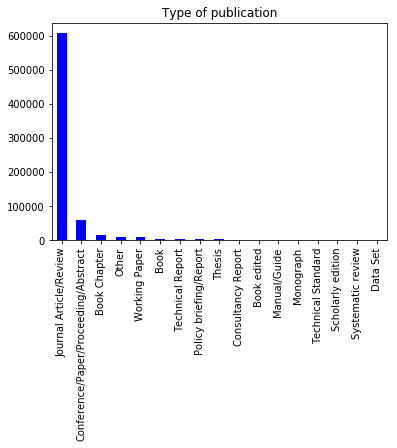

In [41]:
pubs.type.value_counts().plot.bar(color='blue',title='Type of publication')

In [42]:
pubs['year'] = pubs['datePublished'].apply(get_year)

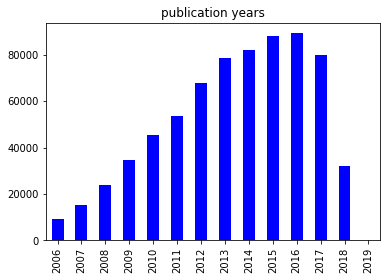

In [43]:
pubs['year'].value_counts().loc[np.arange(2006,2020)].plot.bar(color='blue',title='publication years')

In [44]:
pubs['journalTitle'].value_counts()[:10]

Monthly Notices of the Royal Astronomical Society                                  22962
Journal of High Energy Physics                                                     17475
Physical Review D                                                                  17065
Physical review letters                                                            14234
Physics Letters B                                                                  12653
The Astrophysical Journal                                                          10421
PloS one                                                                            9957
The European physical journal. C, Particles and fields                              6307
Astronomy & Astrophysics                                                            5824
Proceedings of the National Academy of Sciences of the United States of America     4341
Name: journalTitle, dtype: int64

### Discipline coverage check

Here we run outputs vs projects to get who were the funders. We want to check how much cross-organisation coverage there is in the data

We also identify projects that appear in different 'impact' databases

In [69]:
#Containers for the data
impactful_projects= []

impact_funders = [projects['leadFunder'].value_counts()]

impact_names = ['prods','ip','tech','spin','pubs']

for name,data in zip(impact_names,[products,ip,technical,spinouts,pubs]):
    
    #Merges outputs and projects via the product file
    
    merged = pd.merge(
        pd.merge(data,link,left_on='id',right_on='id'),
        projects,left_on='project_id',right_on='id')
    
    #number of times that a project appears in an output df
    project_counts = merged['project_id'].value_counts()
    project_counts.name = name
    
    #Put it with the featured projects
    impactful_projects.append(project_counts)
    
    
    #Funder impact by project
    funder_freqs = merged['leadFunder'].value_counts()
    funder_freqs.name = name
    
    #Merges with the outpi
    impact_funders.append(funder_freqs)
    

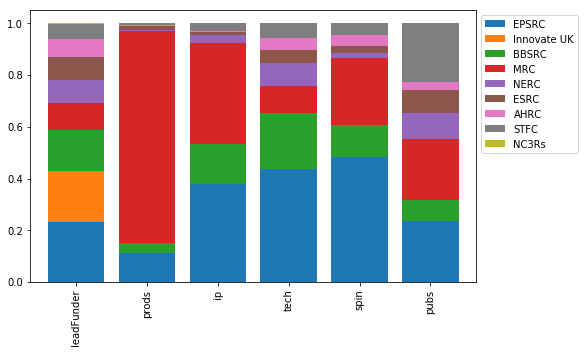

In [50]:
fig,ax = plt.subplots(figsize=(8,5))

pd.concat(impact_funders,axis=1,sort=False).apply(lambda x: x/x.sum(),axis=0).T.plot.bar(stacked=True,ax=ax,width=0.8)

ax.legend(bbox_to_anchor=(1,1))

Some observations:
* No output data for innovate UK
* MRC over-represented in all outputs (not bad for the mission pilots)
* STFC over-represented in publications(physics)

In [70]:
# And the impactful projects

#Concatenate the previous outputs
project_impacts = pd.concat(impactful_projects,axis=1,sort=True).fillna(0)

#Concatenate with the projects file
projects_imp = pd.concat([projects_f.set_index('project_id'),project_impacts],axis=1)

projects_imp.shape

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


(86879, 28)

Fillnas with 0s. 
Should drop innovate from follow-on analyses here given that they don't seem to be tracking the impact of their projects in the same way as research councils.

In [73]:
projects_imp[impact_names] = projects_imp[impact_names].fillna(0)

In [76]:
#What is the correlation between different types of outputs...and level of funding?

projects_imp[impact_names+['amount']].corr()

,prods,ip,tech,spin,pubs,amount
prods,1.000000,0.154113,0.047016,0.094811,0.112599,0.041566
ip,0.154113,1.000000,0.045560,0.198853,0.086280,0.060164
tech,0.047016,0.045560,1.000000,0.089785,0.120521,0.052062
spin,0.094811,0.198853,0.089785,1.000000,0.116723,0.052717
pubs,0.112599,0.086280,0.120521,0.116723,1.000000,0.189787
amount,0.041566,0.060164,0.052062,0.052717,0.189787,1.000000


Lots of potential confounders here - types of projects, disciplines...

#### Some observations for next steps

* Analysis focusing on 2006-2018
* We need to integrate the topic data (new link file)?
* Analyses of TRL/output by field will need to consider differences between disciplines in their outlets. To which extent are the disciplines in a mission field more or less productive than their constituent fields?
* ...



## 2. Process data

* Classify projects into disciplines.
  * I need the project topics for this labelling
* Any TRL tags would go in here

## 3. Query data

### Word embeddings query / Clio query?